### Moving MNIST -> CNN, LSTM

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

In [ ]:
fpath = keras.utils.get_file(
    "moving_mnist.npy",
    "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
)
dataset = np.load(fpath)

dataset = np.swapaxes(dataset, 0, 1)
dataset = dataset[:1000, ...]
dataset = np.expand_dims(dataset, axis=-1)

indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

train_dataset = train_dataset / 255
val_dataset = val_dataset / 255

def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y

x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

819200096/819200096 [==============================] - 28s 0us/step
Training Dataset Shapes: (900, 19, 64, 64, 1), (900, 19, 64, 64, 1)
Validation Dataset Shapes: (100, 19, 64, 64, 1), (100, 19, 64, 64, 1)


### X와 Y의 차이 :
- X는 앞에서 19장, Y는 뒤에서 19장
- 첫번째 프레임인 X[0]의 입력을 모델에 넣음
- 모델이 첫번째 프레임의 다음 프레임인 Z를 예측함
- 예측한 Z가 다음 1번째 프레임인 Y[0]과 동일한지를 BCE로 오차를 계산

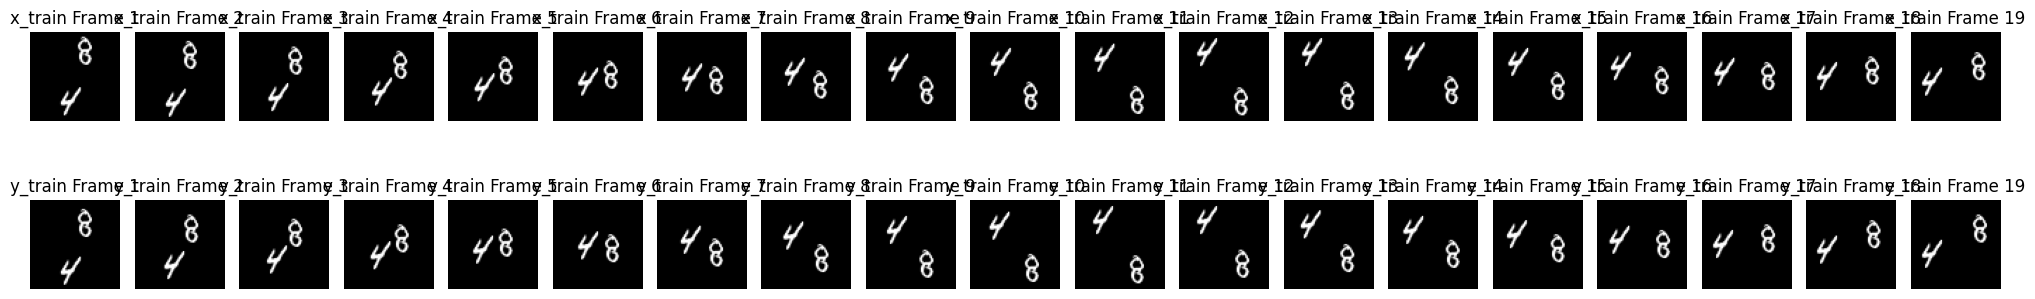

In [ ]:
import matplotlib.pyplot as plt

# 첫 번째 시퀀스 샘플 선택
x_sample = x_train[0]
y_sample = y_train[0]

# 프레임 수
num_frames = x_sample.shape[0]

# 시각화
plt.figure(figsize=(20, 4))
for i in range(num_frames):
    # x_train 프레임
    plt.subplot(2, num_frames, i + 1)
    plt.imshow(x_sample[i, :, :, 0], cmap="gray")
    plt.title(f"x_train Frame {i+1}")
    plt.axis("off")

    # y_train 프레임
    plt.subplot(2, num_frames, num_frames + i + 1)
    plt.imshow(y_sample[i, :, :, 0], cmap="gray")
    plt.title(f"y_train Frame {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()


## 데이터 시각화

518 데이터의 프레임별 이미지.
(900, 20, 64, 64, 1)


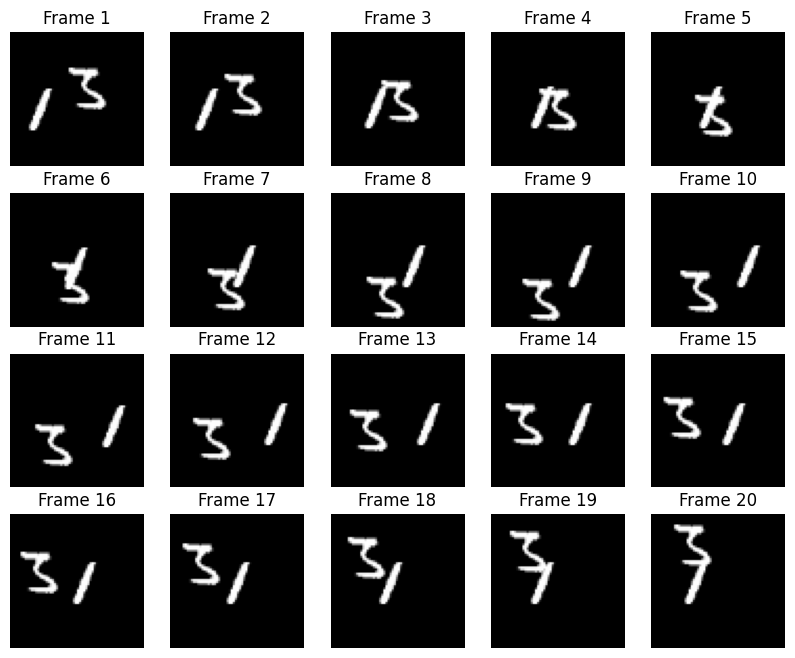

In [ ]:
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

print(f"{data_choice} 데이터의 프레임별 이미지.")
print(train_dataset.shape)
plt.show()

## ConvLSTM 사용

**ConvLSTM을 사용한 예측 원리**  
ConvLSTM은 LSTM과 합성곱 신경망의 장점을 결합하여 시계열 데이터(예: 비디오 프레임)의 시간적, 공간적 패턴을 동시에 학습합니다.

1. 입력 데이터 처리

2. 합성곱 연산을 통한 공간적 특징 추출

3. LSTM 셀을 통한 시간적 패턴 학습

4. 출력 생성
학습된 시간적, 공간적 패턴을 바탕으로 ConvLSTM은 미래 프레임을 예측합니다. 예측된 출력은 다시 합성곱 연산을 거쳐 최종 결과(미래 프레임)를 생성합니다.

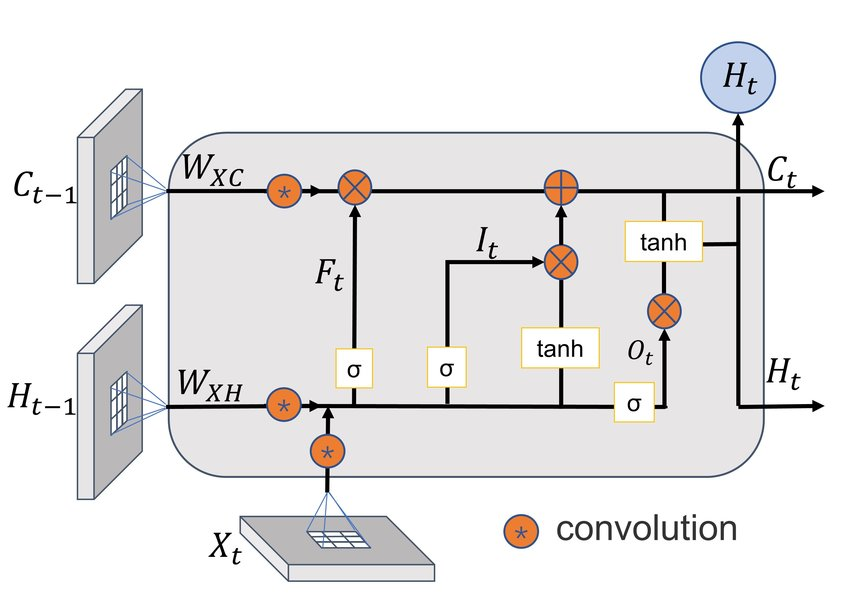

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Conv3D
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='tensorflow')

# 간단한 모델 정의
model = Sequential([
    ConvLSTM2D(
        filters=20,
        kernel_size=(3, 3),
        input_shape=(None, 64, 64, 1),
        padding='same',
        return_sequences=True
    ),
    BatchNormalization(),
    ConvLSTM2D(
        filters=20,
        kernel_size=(3, 3),
        padding='same',
        return_sequences=True
    ),
    BatchNormalization(),
    Conv3D(
        filters=1,
        kernel_size=(3, 3, 3),
        activation='sigmoid',
        padding='same'
    )
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.fit(
    x_train,
    y_train,
    batch_size=10,
    epochs=10,
    validation_data=(x_val, y_val)
)

/Users/chaeny/anaconda3/envs/myenv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10


2024-07-02 15:15:28.351134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


90/90 ━━━━━━━━━━━━━━━━━━━━ 393s 4s/step - accuracy: 0.7155 - loss: 0.6195 - val_accuracy: 0.9302 - val_loss: 0.3770
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 382s 4s/step - accuracy: 0.9295 - loss: 0.0867 - val_accuracy: 0.9302 - val_loss: 0.1964
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 380s 4s/step - accuracy: 0.9316 - loss: 0.0435 - val_accuracy: 0.9302 - val_loss: 0.1714
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 376s 4s/step - accuracy: 0.9299 - loss: 0.0368 - val_accuracy: 0.9303 - val_loss: 0.1391
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 375s 4s/step - accuracy: 0.9316 - loss: 0.0333 - val_accuracy: 0.9307 - val_loss: 0.0952
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 360s 4s/step - accuracy: 0.9302 - loss: 0.0317 - val_accuracy: 0.9318 - val_loss: 0.0609
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 374s 4s/step - accuracy: 0.9317 - loss: 0.0306 - val_accuracy: 0.9326 - val_loss: 0.0362
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 376s 4s/step - accuracy: 0.9312 - loss: 0.0296 - val_accuracy: 0.9324 - val_loss: 0.

In [ ]:
# 모델 저장
model.save("day7_team2_moving_mnist_convlstm2d.keras")

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, None, 64, 64,   │        15,200 │
│                                 │ 20)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, None, 64, 64,   │            80 │
│ (BatchNormalization)            │ 20)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)      │ (None, None, 64, 64,   │        28,880 │
│                                 │ 20)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, None, 64, 64,   │            80 │
│ (BatchNormalization)            │ 20)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, None, 64, 64,   │           541 │
│                                 │ 1)                     │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,185 (524.16 KB)

 Trainable params: 44,701 (174.61 KB)

 Non-trainable params: 80 (320.00 B)

 Optimizer params: 89,404 (349.24 KB)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

example = x_val[:10]
predicted = model.predict(example)

for i in range(10):
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))

    # 실제 이미지와 예측된 이미지의 픽셀 값 차이 출력
    print(f"Example {i+1}:")
    print("Actual Frame:")
    print(np.round(example[i, -1, :, :, 0], 2))
    print("Predicted Frame:")
    print(np.round(predicted[i, -1, :, :, 0], 2))

    # 실제 이미지와 예측된 이미지 시각화
    axs[0].imshow(example[i, -1, :, :, 0], cmap='gray')
    axs[0].set_title('Actual')
    axs[1].imshow(predicted[i, -1, :, :, 0], cmap='gray')
    axs[1].set_title('Predicted')

    # 이미지 저장
    plt.savefig(f'frame_prediction_{i+1}.png')
    plt.show()

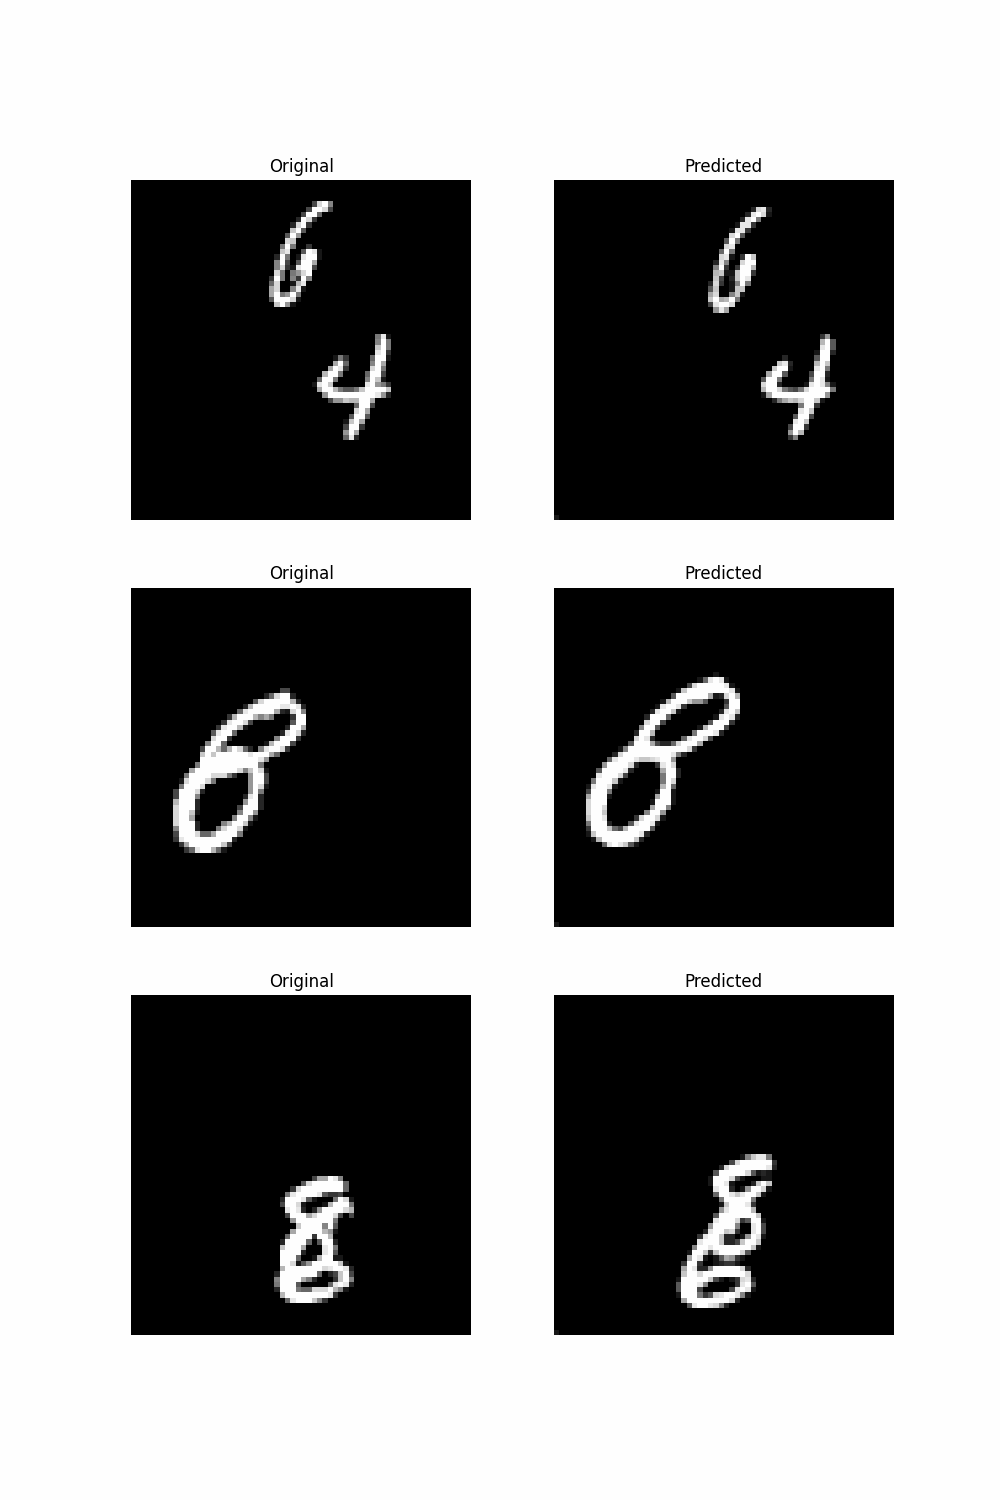

## TimeDistributed + Conv2d + LSTM

In [ ]:
from keras.layers import Input, Conv2D, LSTM, TimeDistributed, Dense, Flatten, Reshape, BatchNormalization
from keras.models import Model

# 모델 구성
input_shape = (None, 64, 64, 1)  # 시퀀스 길이를 None으로 설정

input_tensor = Input(shape=input_shape)

# TimeDistributed Conv2D 레이어
x = TimeDistributed(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))(input_tensor)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(Flatten())(x)

# LSTM 레이어
x = LSTM(64, return_sequences=True)(x)
x = LSTM(64, return_sequences=True)(x)

# 출력 레이어
x = TimeDistributed(Dense(64*64, activation='sigmoid'))(x)
output = Reshape((-1, 64, 64, 1))(x)

# 모델 구성 및 컴파일
model = Model(inputs=input_tensor, outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam')

# 모델 요약
model.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, None, 64, 64, 1   0         
                             )]                                  
                                                                 
 time_distributed_12 (TimeD  (None, None, 64, 64, 64   640       
 istributed)                 )                                   
                                                                 
 time_distributed_13 (TimeD  (None, None, 64, 64, 64   256       
 istributed)                 )                                   
                                                                 
 time_distributed_14 (TimeD  (None, None, 64, 64, 64   36928     
 istributed)                 )                                   
                                                                 
 time_distributed_15 (TimeD  (None, None, 64, 64, 64   256 

In [ ]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 20
batch_size = 5

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/20
180/180 [==============================] - 16s 70ms/step - loss: 0.2353 - val_loss: 0.1691 - lr: 0.0010
Epoch 2/20
180/180 [==============================] - 11s 63ms/step - loss: 0.1679 - val_loss: 0.1666 - lr: 0.0010
Epoch 3/20
180/180 [==============================] - 11s 62ms/step - loss: 0.1667 - val_loss: 0.1660 - lr: 0.0010
Epoch 4/20
180/180 [==============================] - 11s 63ms/step - loss: 0.1663 - val_loss: 0.1657 - lr: 0.0010
Epoch 5/20
180/180 [==============================] - 11s 62ms/step - loss: 0.1661 - val_loss: 0.1659 - lr: 0.0010
Epoch 6/20
180/180 [==============================] - 11s 62ms/step - loss: 0.1660 - val_loss: 0.1654 - lr: 0.0010
Epoch 7/20
180/180 [==============================] - 11s 63ms/step - loss: 0.1660 - val_loss: 0.1653 - lr: 0.0010
Epoch 8/20
180/180 [==============================] - 11s 62ms/step - loss: 0.1659 - val_loss: 0.1654 - lr: 0.0010
Epoch 9/20
180/180 [==============================] - 11s 62ms/step - loss: 0.16

1/1 [==============================] - 0s 22ms/step


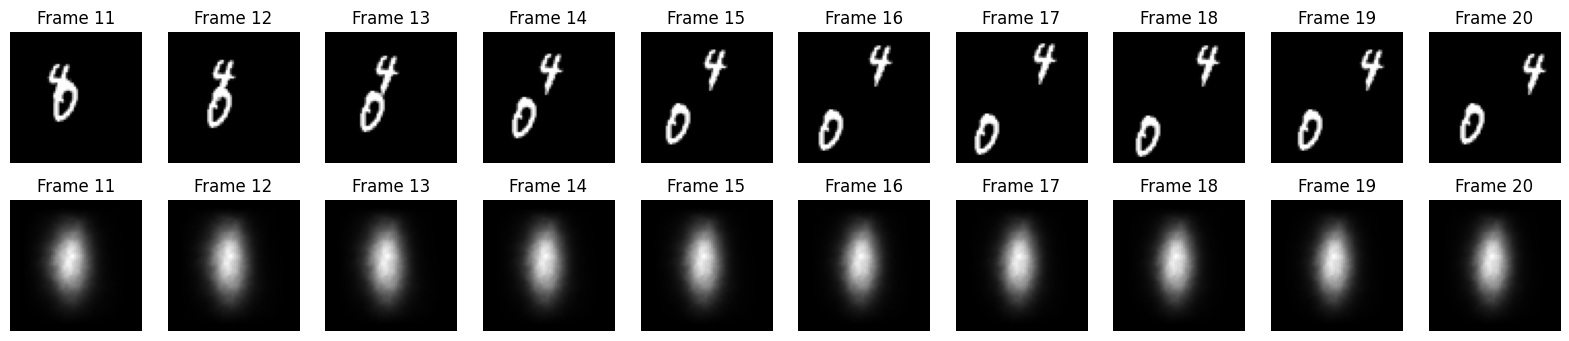

In [ ]:
# Select a random example from the validation dataset.
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

# Pick the first/last ten frames from the example.
frames = example[:10, ...]
original_frames = example[10:, ...]

# Predict a new set of 10 frames.
for _ in range(10):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Display the figure.
plt.show()

In [ ]:
# Select a few random examples from the dataset.
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

# Iterate over the examples and predict the frames.
predicted_videos = []
for example in examples:
    # Pick the first/last ten frames from the example.
    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    # Predict a new set of 10 frames.
    for i in range(10):
        # Extract the model's prediction and post-process it.
        frames = example[: 10 + i + 1, ...]
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        new_predictions[i] = predicted_frame

    # Create and save GIFs for each of the ground truth/prediction images.
    for frame_set in [original_frames, new_predictions]:
        # Construct a GIF from the selected video frames.
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        # Construct a GIF from the frames.
        with io.BytesIO() as gif:
            imageio.mimsave(gif, current_frames, "GIF", duration=200)
            predicted_videos.append(gif.getvalue())

# Display the videos.
print(" Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    # Construct and display an `HBox` with the ground truth and prediction.
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i]),
            widgets.Image(value=predicted_videos[i + 1]),
        ]
    )
    display(box)

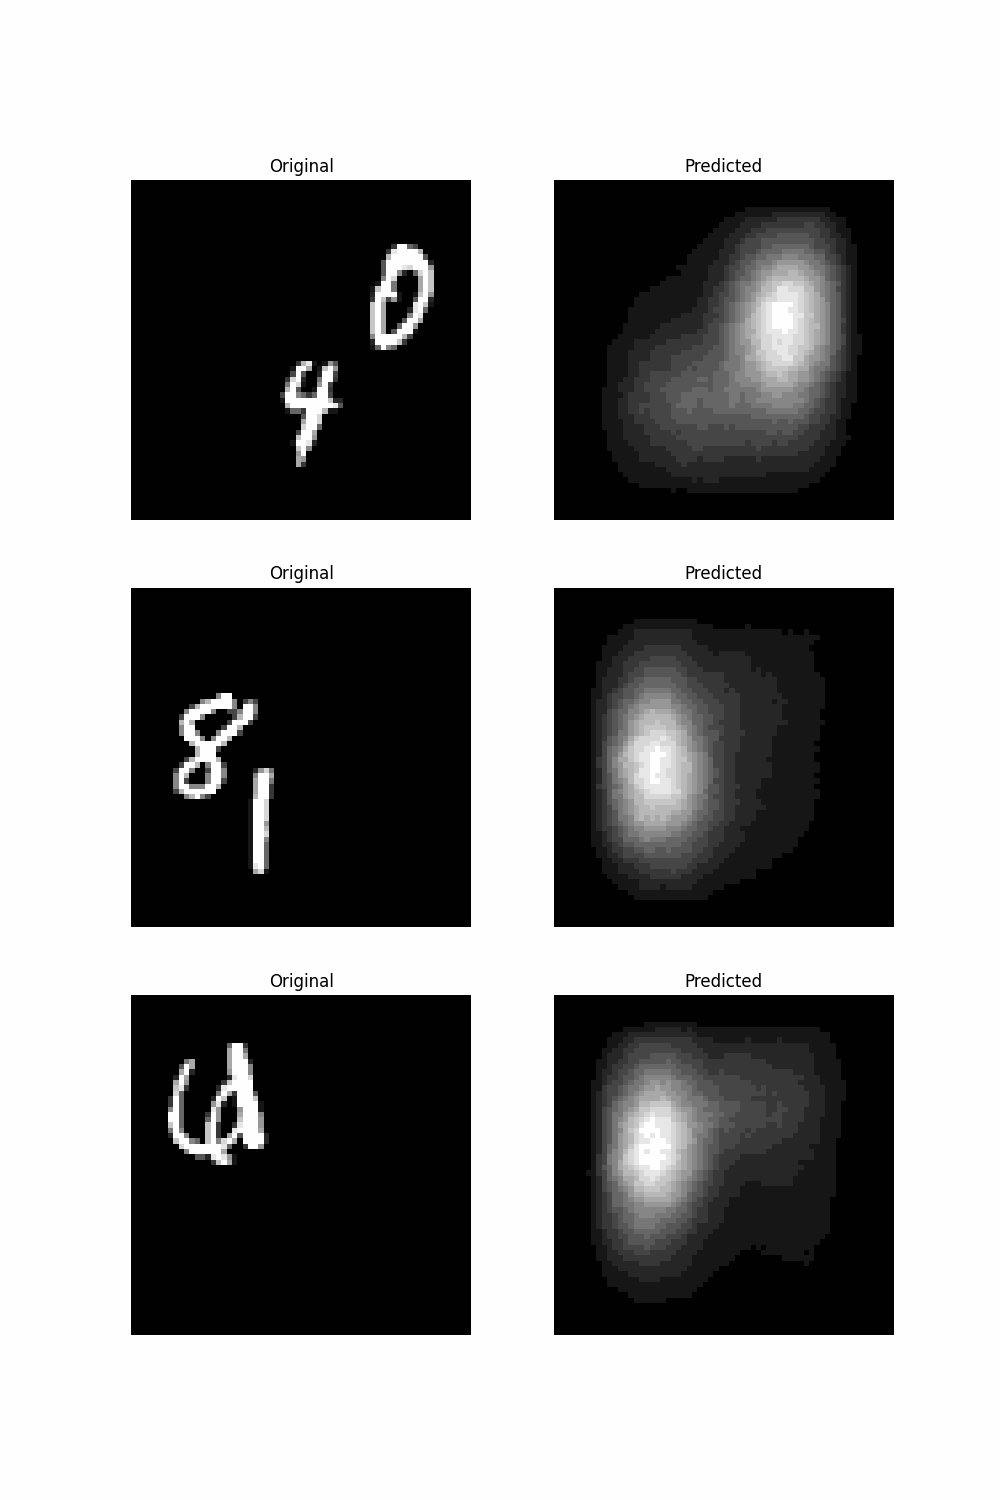

## 3D Conv + LSTM

In [ ]:
from keras.layers import Lambda
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv3D, Conv3DTranspose, LSTM, TimeDistributed, Dense, Flatten, Input, Reshape
from keras.layers import BatchNormalization
from keras.models import Model
import tensorflow as tf




# Conv3D 연산을 수작업으로 수행하는 함수 정의
def apply_conv3d_to_sequence(input_tensor):
    conv_model = Sequential()
    conv_model.add(Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=(None, 64, 64, 1)))
    conv_model.add(BatchNormalization())
    conv_model.add(Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
    conv_model.add(BatchNormalization())
    return conv_model(input_tensor)

# 입력 레이어
input_tensor = layers.Input(shape=(None, *x_train.shape[2:]))

# Conv3D 연산 적용
conv_out = apply_conv3d_to_sequence(input_tensor)

# Conv3D 출력 형상 변경
conv_out_shape = np.prod(conv_out.shape[2:])
conv_out = Reshape((-1, conv_out_shape))(conv_out)

# LSTM 레이어
lstm_out = LSTM(64, return_sequences=True)(conv_out)
lstm_out = LSTM(64, return_sequences=True)(lstm_out)

# 출력 레이어
output = Dense(64*64, activation='sigmoid')(lstm_out)
output = Reshape((-1, 64, 64, 1))(output)

# 모델 구성 및 컴파일
model = Model(inputs=input_tensor, outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam')

# 모델 요약
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, 64, 64, 1   0         
                             )]                                  
                                                                 
 sequential (Sequential)     (None, None, 64, 64, 64   112960    
                             )                                   
                                                                 
 reshape (Reshape)           (None, None, 262144)      0         
                                                                 
 lstm (LSTM)                 (None, None, 64)          67125504  
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          33024     
                                                                 
 dense (Dense)               (None, None, 4096)        2662

In [ ]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 20
batch_size = 5

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/20
180/180 [==============================] - 22s 90ms/step - loss: 0.2349 - val_loss: 0.1690 - lr: 0.0010
Epoch 2/20
180/180 [==============================] - 13s 75ms/step - loss: 0.1678 - val_loss: 0.1668 - lr: 0.0010
Epoch 3/20
180/180 [==============================] - 14s 75ms/step - loss: 0.1666 - val_loss: 0.1658 - lr: 0.0010
Epoch 4/20
180/180 [==============================] - 14s 75ms/step - loss: 0.1656 - val_loss: 0.1657 - lr: 0.0010
Epoch 5/20
180/180 [==============================] - 14s 75ms/step - loss: 0.1635 - val_loss: 0.1617 - lr: 0.0010
Epoch 6/20
180/180 [==============================] - 14s 75ms/step - loss: 0.1573 - val_loss: 0.1528 - lr: 0.0010
Epoch 7/20
180/180 [==============================] - 14s 75ms/step - loss: 0.1488 - val_loss: 0.1457 - lr: 0.0010
Epoch 8/20
180/180 [==============================] - 13s 75ms/step - loss: 0.1411 - val_loss: 0.1379 - lr: 0.0010
Epoch 9/20
180/180 [==============================] - 13s 75ms/step - loss: 0.13

1/1 [==============================] - 0s 394ms/step


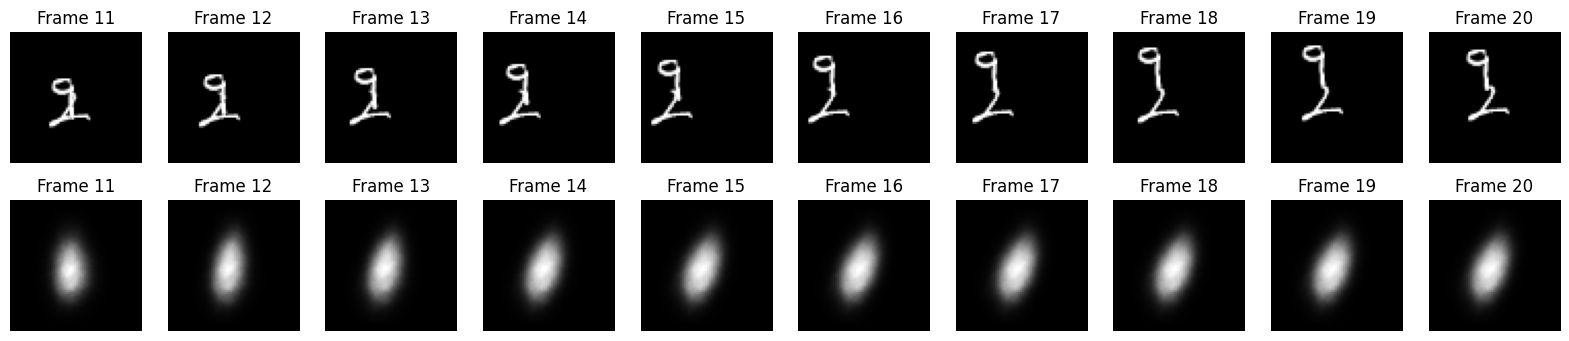

In [ ]:
# Select a random example from the validation dataset.
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

# Pick the first/last ten frames from the example.
frames = example[:10, ...]
original_frames = example[10:, ...]

# Predict a new set of 10 frames.
for _ in range(10):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Display the figure.
plt.show()

In [ ]:
# Select a few random examples from the dataset.
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

# Iterate over the examples and predict the frames.
predicted_videos = []
for example in examples:
    # Pick the first/last ten frames from the example.
    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    # Predict a new set of 10 frames.
    for i in range(10):
        # Extract the model's prediction and post-process it.
        frames = example[: 10 + i + 1, ...]
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        new_predictions[i] = predicted_frame

    # Create and save GIFs for each of the ground truth/prediction images.
    for frame_set in [original_frames, new_predictions]:
        # Construct a GIF from the selected video frames.
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        # Construct a GIF from the frames.
        with io.BytesIO() as gif:
            imageio.mimsave(gif, current_frames, "GIF", duration=200)
            predicted_videos.append(gif.getvalue())

# Display the videos.
print(" Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    # Construct and display an `HBox` with the ground truth and prediction.
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i]),
            widgets.Image(value=predicted_videos[i + 1]),
        ]
    )
    display(box)

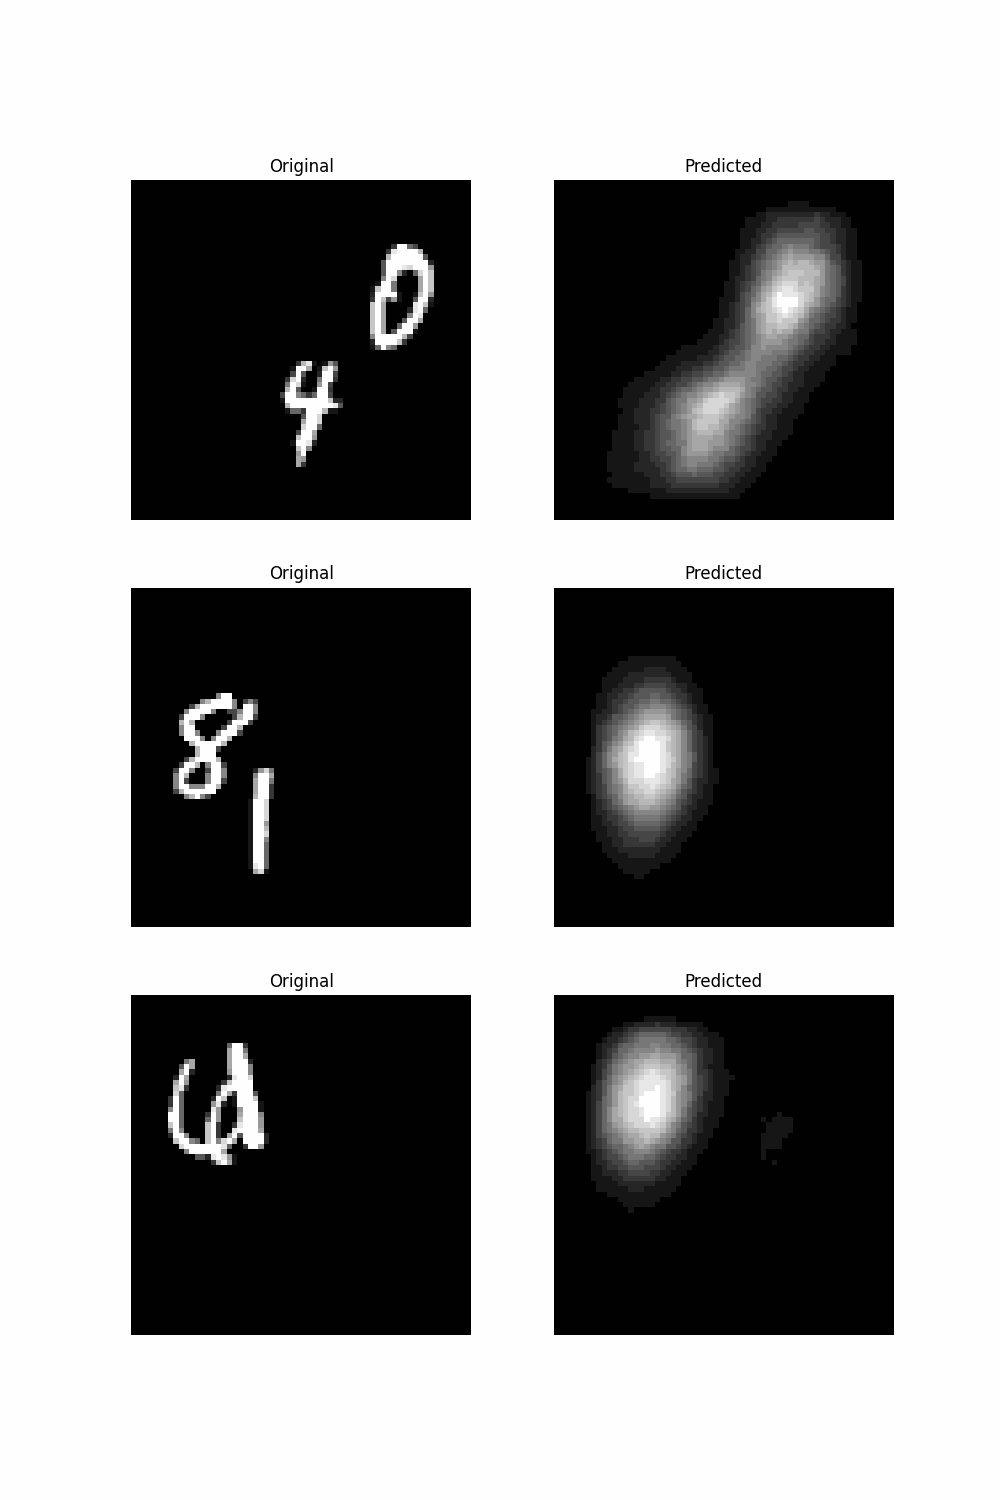

## CONV3D 모델

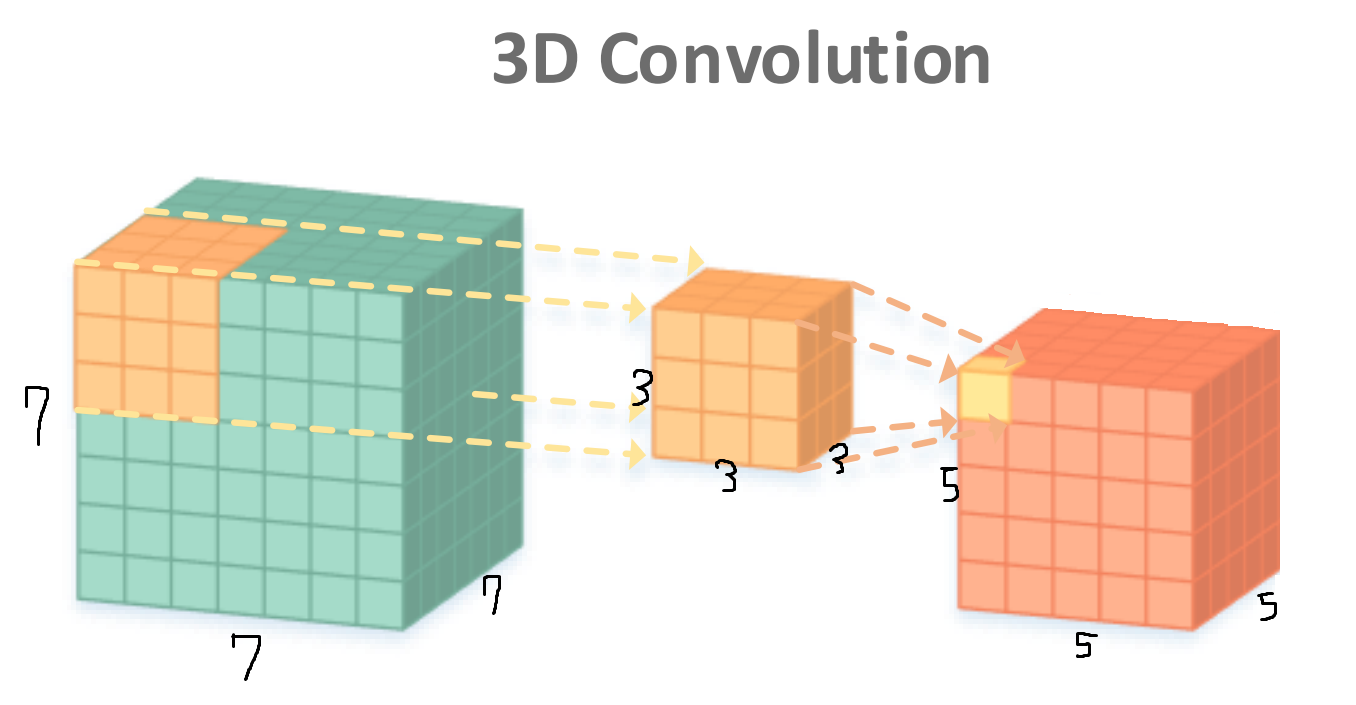

In [ ]:
from tensorflow.keras import layers, models, optimizers, losses

def build_conv3d_model(input_shape):
    inp = layers.Input(shape=input_shape)

    # Conv3D
    x = layers.Conv3D(64, (3, 3, 3), padding="same", activation="relu")(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Conv3D(64, (3, 3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv3D(64, (3, 3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)

    # Output Conv3D
    x = layers.Conv3D(1, (3, 3, 3), activation="sigmoid", padding="same")(x)

    model = models.Model(inp, x)
    model.compile(loss=losses.binary_crossentropy, optimizer=optimizers.Adam())
    return model

height = 64
width = 64
channels = 1

input_shape = (None, height, width, channels)
model = build_conv3d_model(input_shape)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, None, 64, 64, 1   0         
                             )]                                  
                                                                 
 conv3d_13 (Conv3D)          (None, None, 64, 64, 64   1792      
                             )                                   
                                                                 
 batch_normalization_12 (Ba  (None, None, 64, 64, 64   256       
 tchNormalization)           )                                   
                                                                 
 conv3d_14 (Conv3D)          (None, None, 64, 64, 64   110656    
                             )                                   
                                                                 
 batch_normalization_13 (Ba  (None, None, 64, 64, 64   256 

In [ ]:
print(x_train.shape)
print(y_train.shape)

(900, 19, 64, 64, 1)
(900, 19, 64, 64, 1)


### 모델학습

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

epochs = 20
batch_size = 5

model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/20
180/180 [==============================] - 42s 193ms/step - loss: 0.1395 - val_loss: 0.2336 - lr: 0.0010
Epoch 2/20
180/180 [==============================] - 35s 192ms/step - loss: 0.0303 - val_loss: 0.9546 - lr: 0.0010
Epoch 3/20
180/180 [==============================] - 34s 190ms/step - loss: 0.0278 - val_loss: 0.0835 - lr: 0.0010
Epoch 4/20
180/180 [==============================] - 34s 191ms/step - loss: 0.0268 - val_loss: 0.0356 - lr: 0.0010
Epoch 5/20
180/180 [==============================] - 34s 191ms/step - loss: 0.0264 - val_loss: 0.0265 - lr: 0.0010
Epoch 6/20
180/180 [==============================] - 34s 190ms/step - loss: 0.0265 - val_loss: 0.0258 - lr: 0.0010
Epoch 7/20
180/180 [==============================] - 34s 191ms/step - loss: 0.0260 - val_loss: 0.0255 - lr: 0.0010
Epoch 8/20
180/180 [==============================] - 34s 190ms/step - loss: 0.0255 - val_loss: 0.0258 - lr: 0.0010
Epoch 9/20
180/180 [==============================] - 34s 191ms/step - l

1/1 [==============================] - 0s 177ms/step


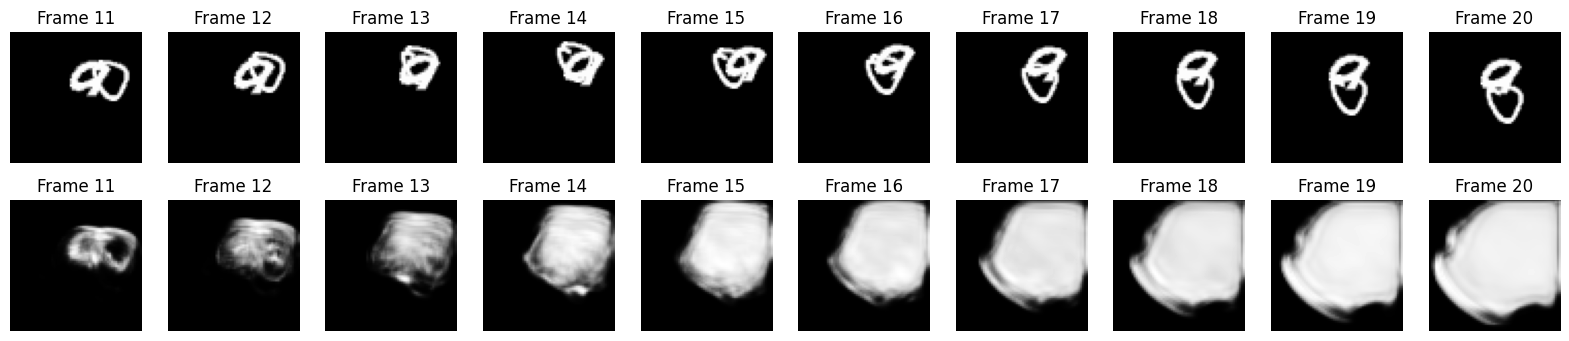

In [ ]:
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

frames = example[:10, ...]
original_frames = example[10:, ...]

for _ in range(10):
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    frames = np.concatenate((frames, predicted_frame), axis=0)

fig, axes = plt.subplots(2, 10, figsize=(20, 4))

for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

plt.show()

In [ ]:
from IPython.display import HTML, display
import io
import imageio
import ipywidgets as widgets
from IPython.display import display, Image
from ipywidgets import HBox

# 예측된 비디오들을 저장할 리스트
predicted_videos = []

# 예제로 선택할 데이터
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

# 예제별로 예측 프레임 생성 및 GIF로 변환
for example in examples:
    frames = example[:10, ...]  # 처음 10프레임
    original_frames = example[10:, ...]  # 실제 프레임

    new_predictions = np.zeros(shape=(10, *frames[0].shape))  # 예측 프레임 초기화

    # 예측 프레임 생성
    for i in range(10):
        frames = example[: 10 + i + 1, ...]  # 현재까지의 프레임
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        new_predictions[i] = predicted_frame

    # 원본 프레임과 예측 프레임을 GIF로 변환
    for frame_set in [original_frames, new_predictions]:
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        with io.BytesIO() as gif:
            imageio.mimsave(gif, current_frames, "GIF", duration=200)
            predicted_videos.append(gif.getvalue())

# HTML을 사용하여 GIF를 반복 재생하도록 표시
def display_gif_in_loop(gif_bytes):
    html_str = f"<img src='data:image/gif;base64,{gif_bytes.decode('ascii')}' loop='true' />"
    display(HTML(html_str))

print("Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    box = HBox([
        widgets.Image(value=predicted_videos[i]),
        widgets.Image(value=predicted_videos[i + 1]),
    ])
    display(box)


1/1 [==============================] - 0s 18ms/step
Truth	Prediction


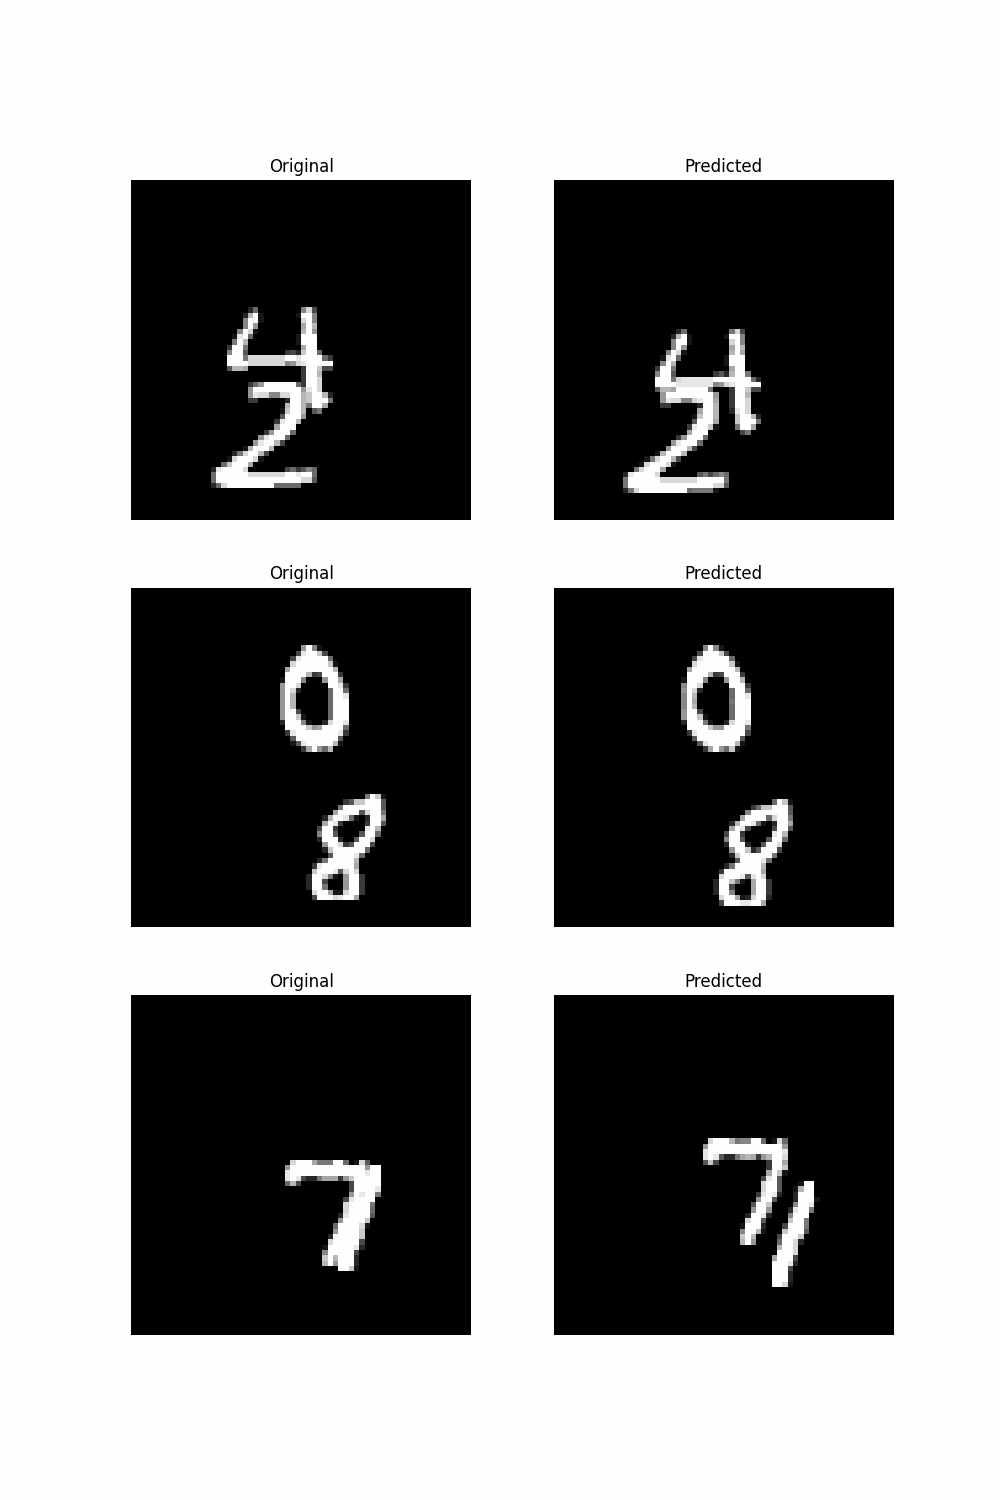

## 결론

- LSTM은 시계열인 숫자의 움직임을 학습하고, 합성층은 공간적 특징을 추출하여 숫자를 표현함.
- 이미지가 뿌옇게 되는 원리는. 인코더디코더를 통한 차원축소가 없어서 합성곱을 통해 특징이 희석되기 때문